In [1]:
import string
import collections
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, TensorDataset
import re
from tqdm import tqdm
import numpy as np
import random
import time
import scikitplot as skplt
%matplotlib inline

In [2]:
path = '../../Dataset/A/SemEval2017-task4-dev.subtask-A.english.INPUT.txt'

In [3]:
# Read data from txt file
data_df = pd.read_table(path,sep='\t',header=None)
data_df = data_df.drop(columns=3)
data_df.columns = ['ID','Sentiment','Text']
data_df

,ID,Sentiment,Text
0,619950566786113536,neutral,"Picturehouse's, Pink Floyd's, 'Roger Waters: T..."
1,619969366986235905,neutral,Order Go Set a Watchman in store or through ou...
2,619971047195045888,negative,If these runway renovations at the airport pre...
3,619974445185302528,neutral,If you could ask an onstage interview question...
4,619987808317407232,positive,A portion of book sales from our Harper Lee/Go...
...,...,...,...
20627,681877834982232064,neutral,@ShaquilleHoNeal from what I think you're aski...
20628,681879579129200640,positive,"Iran ranks 1st in liver surgeries, Allah bless..."
20629,681883903259357184,neutral,Hours before he arrived in Saudi Arabia on Tue...
20630,681904976860327936,negative,@VanityFair Alex Kim Kardashian worth how to ...


In [6]:
data_df.loc[:,'Sentiment'].value_counts()

neutral     10342
positive     7059
negative     3231
Name: Sentiment, dtype: int64

In [7]:
from ekphrasis.classes.preprocessor import TextPreProcessor
from ekphrasis.classes.tokenizer import SocialTokenizer
from ekphrasis.dicts.emoticons import emoticons

text_processor = TextPreProcessor(
    # terms that will be normalized
    normalize=['url', 'email', 'percent', 'money', 'phone', 'user',
        'time', 'url', 'date', 'number'],
    # terms that will be annotated
    annotate={"hashtag", "allcaps", "elongated", "repeated",
        'emphasis', 'censored'},
    fix_html=True,  # fix HTML tokens
    
    # corpus from which the word statistics are going to be used 
    # for word segmentation 
    segmenter="twitter", 
    
    # corpus from which the word statistics are going to be used 
    # for spell correction
    corrector="twitter", 
    
    unpack_hashtags=True,  # perform word segmentation on hashtags
    unpack_contractions=True,  # Unpack contractions (can't -> can not)
    spell_correct_elong=False,  # spell correction for elongated words
    
    # select a tokenizer. You can use SocialTokenizer, or pass your own
    # the tokenizer, should take as input a string and return a list of tokens
    tokenizer=SocialTokenizer(lowercase=True).tokenize,
    
    # list of dictionaries, for replacing tokens extracted from the text,
    # with other expressions. You can pass more than one dictionaries.
    dicts=[emoticons]
)

D:\Anaconda\lib\site-packages\sklearn\feature_extraction\image.py:167: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int):
D:\Anaconda\lib\site-packages\ekphrasis\classes\tokenizer.py:225: FutureWarning: Possible nested set at position 2190
  self.tok = re.compile(r"({})".format("|".join(pipeline)))


Reading twitter - 1grams ...
Reading twitter - 2grams ...


D:\Anaconda\lib\site-packages\ekphrasis\classes\exmanager.py:14: FutureWarning: Possible nested set at position 42
  regexes = {k.lower(): re.compile(self.expressions[k]) for k, v in


Reading twitter - 1grams ...


In [8]:
#Define the tokenzation function
def tokenize_text(text, option):
    '''
    Tokenize the input text as per specified option
        1: Use python split() function
        2: Use regex to extract alphabets plus 's and 't
        3: Use ekphrasis text_processor.pre_process_doc
        4: Use NLTK word_tokenize(), remove stop words and apply lemmatization
    '''
    if option == 1:
        return text.split()
    elif option == 2:
        return re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', text)
    elif option == 3:
        return [word for word in text_processor.pre_process_doc(text) if (word!='s' and word!='\'')]
    elif option == 4:
        words = [word for word in word_tokenize(text) if (word.isalpha()==1)]
        # Remove stop words
        stop = set(stopwords.words('english'))
        words = [word for word in words if (word not in stop)]
        # Lemmatize words (first noun, then verb)
        wnl = nltk.stem.WordNetLemmatizer()
        lemmatized = [wnl.lemmatize(wnl.lemmatize(word, 'n'), 'v') for word in words]
        return lemmatized
    else:
        print("Please specify option value between 1 and 4")
        return []

In [9]:
# Import package and download required resources
from collections import Counter
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

[nltk_data] Error loading punkt: <urlopen error [Errno 11004]
[nltk_data]     getaddrinfo failed>
[nltk_data] Error loading wordnet: <urlopen error [Errno 11004]
[nltk_data]     getaddrinfo failed>
[nltk_data] Error loading stopwords: <urlopen error [Errno 11004]
[nltk_data]     getaddrinfo failed>


In [10]:
# Create vocabulary to int dictionary
def create_vocab(messages, show_graph=False):
    corpus = []
    for message in tqdm(messages, desc="Tokenizaing"):
        tokens = tokenize_text(message, 3) # Use option 3
        corpus.extend(tokens)
    print("The number of all words: {}".format(len(corpus)))

    # Create Counter
    counts = Counter(corpus)
    print("The number of unique words: {}".format(len(counts)))

    # Create BoW
    bow = sorted(counts, key=counts.get, reverse=True)
    print("Top 40 frequent words: {}".format(bow[:40]))

    # Indexing vocabrary, starting from 1.
    vocab = {word: ii for ii, word in enumerate(counts, 1)}
    id2vocab = {v: k for k, v in vocab.items()}

    if show_graph:
        from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
        import seaborn as sns
        # Generate Word Cloud image
        text = " ".join(corpus)
        stopwords = set(STOPWORDS)
        stopwords.update(["will", "report", "reporting", "market", "stock", "share"])

        wordcloud = WordCloud(stopwords=stopwords, max_font_size=50, max_words=100, background_color="white", collocations=False).generate(text)
        plt.figure(figsize=(15,7))
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis("off")
        plt.show()

        # Show most frequent words in a bar graph
        most = counts.most_common()[:80]
        x, y = [], []
        for word, count in most:
            if word not in stopwords:
                x.append(word)
                y.append(count)
        plt.figure(figsize=(12,10))
        sns.barplot(x=y, y=x)
        plt.show()

    return vocab

messages = list(data_df.Text)
vocab= create_vocab(messages)

Tokenizaing: 100%|█████████████████████████████████████████████████████████████| 20632/20632 [00:08<00:00, 2560.20it/s]


The number of all words: 493747
The number of unique words: 22054
Top 40 frequent words: ['.', 'the', ',', 'to', 'i', '<user>', '<url>', 'in', 'a', 'and', 'on', '<number>', 'of', '<repeated>', '<hashtag>', '</hashtag>', 'is', 'for', '!', '<allcaps>', '</allcaps>', 'it', 'you', 'not', 'may', '-', 'with', 'be', 'tomorrow', '?', '"', ':', 'at', 'that', 'have', 'he', 'will', 'th', '1', 'but']


In [11]:
# load word embedding
def load_my_vecs(path):
    word2vecs = []
    word2idx = {}
    with open(path, encoding="utf-8") as f:
        i  = 0
        lines = f.readlines()[1:]
        for line in lines:
            values = line.split(" ")
            word = values[0]
            # word = word.lower()
            if word in vocab:
                i += 1
                vector = []
                for count, val in enumerate(values):
                    if count == 0:
                        continue
                    vector.append(float(val))
                word2vecs.append(vector)
                word2idx[word] = i
    return word2vecs, word2idx

word2vec, word2idx = load_my_vecs("../../model/datastories.twitter.300d.txt")

In [12]:
def encoded_label(sentiment):
    if sentiment == 'negative':
        return 0
    elif sentiment == 'neutral':
        return 1
    else:
        return 2

data_df['label'] = data_df.Sentiment.apply(encoded_label)
data_df

,ID,Sentiment,Text,label
0,619950566786113536,neutral,"Picturehouse's, Pink Floyd's, 'Roger Waters: T...",1
1,619969366986235905,neutral,Order Go Set a Watchman in store or through ou...,1
2,619971047195045888,negative,If these runway renovations at the airport pre...,0
3,619974445185302528,neutral,If you could ask an onstage interview question...,1
4,619987808317407232,positive,A portion of book sales from our Harper Lee/Go...,2
...,...,...,...,...
20627,681877834982232064,neutral,@ShaquilleHoNeal from what I think you're aski...,1
20628,681879579129200640,positive,"Iran ranks 1st in liver surgeries, Allah bless...",2
20629,681883903259357184,neutral,Hours before he arrived in Saudi Arabia on Tue...,1
20630,681904976860327936,negative,@VanityFair Alex Kim Kardashian worth how to ...,0


In [13]:
weight = torch.FloatTensor(word2vec)

In [15]:
import torch.nn as nn
class BiLSTM_Attention(nn.Module):

    def __init__(self, vocab_size, embedding_dim, hidden_dim, n_layers, weight):

        super(BiLSTM_Attention, self).__init__()

        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        embedding = nn.Embedding.from_pretrained(weight)
        self.rnn = nn.LSTM(embedding_dim, hidden_dim, num_layers=n_layers, bidirectional=True, dropout=0.5)
        self.fc = nn.Linear(hidden_dim * 2, 3)
        self.dropout = nn.Dropout(0.5)

        # Initialize the hidden state
        self.w_omega = nn.Parameter(torch.Tensor(hidden_dim * 2, hidden_dim * 2))
        self.u_omega = nn.Parameter(torch.Tensor(hidden_dim * 2, 1))

        nn.init.uniform_(self.w_omega, -0.1, 0.1)
        nn.init.uniform_(self.u_omega, -0.1, 0.1)


    def attention_net(self, x):       #x:[batch, seq_len, hidden_dim*2]

        u = torch.tanh(torch.matmul(x, self.w_omega))         #[batch, seq_len, hidden_dim*2]
        att = torch.matmul(u, self.u_omega)                   #[batch, seq_len, 1]
        att_score = F.softmax(att, dim=1)

        scored_x = x * att_score                              #[batch, seq_len, hidden_dim*2]

        context = torch.sum(scored_x, dim=1)                  #[batch, hidden_dim*2]
        return context


    def forward(self, x):
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        embedding = self.dropout(self.embedding(x))       #[seq_len, batch, embedding_dim]
        #embedding = embedding + (0.2**0.5)*torch.randn(embedding.shape,device=device)

        # output: [seq_len, batch, hidden_dim*2]     hidden/cell: [n_layers*2, batch, hidden_dim]
        output, (final_hidden_state, final_cell_state) = self.rnn(embedding)
        output = output.permute(1, 0, 2)                  #[batch, seq_len, hidden_dim*2]
        
        output = output + (0.2**0.5)*torch.randn(output.shape,device=device)

        attn_output = self.attention_net(output)
        logit = self.fc(attn_output)
        return logit
    
    
# Define LSTM Tokenizer
def tokenizer_lstm(X, vocab, seq_len, padding):
    '''
    Returns tokenized tensor with left/right padding at the specified sequence length
    '''
    X_tmp = np.zeros((len(X), seq_len), dtype=np.int64)
    for i, text in enumerate(X):
        tokens = tokenize_text(text, 3) 
        token_ids = [vocab[word] for word in tokens if word in word2idx.keys()]
        end_idx = min(len(token_ids), seq_len)
        if padding == 'right':
            X_tmp[i,:end_idx] = token_ids[:end_idx]
        elif padding == 'left':
            start_idx = max(seq_len - len(token_ids), 0)
            X_tmp[i,start_idx:] = token_ids[:end_idx]

    return torch.tensor(X_tmp, dtype=torch.int64)

In [16]:
from torch.utils.data import DataLoader, Dataset

# Define a DataSet Class which simply return (x, y) pair
class SimpleDataset(Dataset):
    def __init__(self, x, y):
        self.datalist=[(x[i], y[i]) for i in range(len(y))]
    def __len__(self):
        return len(self.datalist)
    def __getitem__(self,idx):
        return self.datalist[idx]

# Data Loader
def create_data_loader(X, y, indices, batch_size, shuffle):
    X_sampled = np.array(X, dtype=object)[indices]
    y_sampled = np.array(y)[indices].astype(int)
    dataset = SimpleDataset(X_sampled, y_sampled)
    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    return loader

In [17]:
from sklearn.model_selection import StratifiedShuffleSplit
import torch.nn.functional as F
from torch.autograd import Variable

def train_cycles(X_all, y_all, vocab, num_samples, model_type, epochs, patience, batch_size, seq_len, lr, clip):
    result = pd.DataFrame(columns=['Recall','Accuracy', 'F1(macro)', 'Total_Time', 'ms/text'], index=num_samples)

    for n in num_samples:
        print("")
        print("############### Start training for %d samples ###############" %n)

        # Stratified sampling
        train_size = n / len(y_all)
        sss = StratifiedShuffleSplit(n_splits=1, train_size=train_size*0.8, test_size=train_size*0.2 , random_state=random.randint(0,9999))
        train_indices, valid_indices = next(sss.split(X_all, y_all))

        # Sample input data
        train_loader = create_data_loader(X_all, y_all, train_indices, batch_size, True)
        valid_loader = create_data_loader(X_all, y_all, valid_indices, batch_size, False)

        if model_type == 'LSTM':
            model = BiLSTM_Attention(len(word2vec)+1, embedding_dim=300, hidden_dim=256, n_layers=2, weight=weight)
            model.embedding.weight.data.uniform_(-1, 1)        
        elif model_type == 'BERT':
            model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)

        start_time = time.perf_counter() # use time.process_time() for CPU time
        rec, acc, f1, model_trained = train_nn_model(model, model_type, train_loader, valid_loader, word2idx, epochs, patience, batch_size, seq_len, lr, clip)
        end_time = time.perf_counter() # use time.process_time() for CPU time
        duration = end_time - start_time
        print("Process Time (sec): {}".format(duration))
        result.loc[n] = (round(rec,4), round(acc,4), round(f1,4), duration, duration/n*1000)

    return result, model_trained

# Define metrics
from sklearn.metrics import recall_score, accuracy_score, f1_score

def metric(y_true, y_pred):
    rec = recall_score(y_true, y_pred, average='macro')
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='macro')
    return rec, acc, f1

In [18]:
from transformers import AdamW as AdamW_HF, get_linear_schedule_with_warmup

def train_nn_model(model, model_type, train_loader, valid_loader, vocab, epochs, patience, batch_size, seq_len, lr, clip):
    # Set variables
    num_total_opt_steps = int(len(train_loader) * epochs)
    eval_every = len(train_loader) // 5
    warm_up_proportion = 0.1
    print('Total Training Steps: {} ({} batches x {} epochs)'.format(num_total_opt_steps, len(train_loader), epochs))

    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    optimizer = AdamW_HF(model.parameters(), lr=lr, correct_bias=False) 
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=num_total_opt_steps*warm_up_proportion, num_training_steps=num_total_opt_steps)  # PyTorch scheduler
    criterion = nn.CrossEntropyLoss()

    # Set Train Mode
    model.train()

    # Initialise
    rec_train, acc_train, f1_train, loss_train, rec_valid, acc_valid, f1_valid, loss_valid = [], [], [], [], [], [], [], []
    best_rec, early_stop, steps = 0, 0, 0
    class_names = ['0: Negative','1: Neutra;', '2: Positive']

    for epoch in tqdm(range(epochs), desc="Epoch"):
        print('================     epoch {}     ==============='.format(epoch+1))

        #################### Training ####################
        # Initialise
        loss_tmp, loss_cnt = 0, 0
        y_pred_tmp, y_truth_tmp = [], []

        for i, batch in enumerate(train_loader):
            text_batch, labels = batch
            # Skip the last batch of which size is not equal to batch_size
            if labels.size(0) != batch_size:
                break
            steps += 1
            # Reset gradient
            model.zero_grad()
            optimizer.zero_grad()

            # Initialise after the previous training
            if steps % eval_every == 1:
                y_pred_tmp, y_truth_tmp = [], []

            # Tokenize the input and move to device
            text_batch = tokenizer_lstm(text_batch, vocab, seq_len, padding='left').transpose(1,0).to(device)
            labels = torch.tensor(labels, dtype=torch.int64).to(device)

            # Get output and hidden state from the model, calculate the loss
            logits = model(text_batch)
            loss = criterion(logits, labels)

            y_pred_tmp.extend(np.argmax(F.softmax(logits, dim=1).cpu().detach().numpy(), axis=1))
            y_truth_tmp.extend(labels.cpu().numpy())

            # Back prop
            loss.backward()

            # Training Loss
            loss_tmp += loss.item()
            loss_cnt += 1

            # Clip the gradient to prevent the exploading gradient problem in RNN/LSTM
            nn.utils.clip_grad_norm_(model.parameters(), clip)

            # Update Weights and Learning Rate
            optimizer.step()
            scheduler.step()


            #################### Evaluation ####################
            if (steps % eval_every == 0) or ((steps % eval_every != 0) and (steps == len(train_loader))):
                # Evaluate Training
                rec, acc, f1 = metric(y_truth_tmp, y_pred_tmp)
                rec_train.append(rec)
                acc_train.append(acc)
                f1_train.append(f1)
                loss_train.append(loss_tmp/loss_cnt)
                loss_tmp, loss_cnt = 0, 0

                # y_pred_tmp = np.zeros((len(y_valid), 5))
                y_truth_tmp, y_pred_tmp = [], []

                # Move to Evaluation Mode
                model.eval()

                with torch.no_grad():
                    for i, batch in enumerate(valid_loader):
                        text_batch, labels = batch
                        # Skip the last batch of which size is not equal to batch_size
                        if labels.size(0) != batch_size:
                            break

                        if model_type == "LSTM":
                            # Tokenize the input and move to device
                            text_batch = tokenizer_lstm(text_batch, word2idx, seq_len, padding='left').transpose(1,0).to(device)
                            labels = torch.tensor(labels, dtype=torch.int64).to(device)

                            # Get output and hidden state from the model, calculate the loss
                            logits = model(text_batch)
                            loss = criterion(logits, labels)
                
                        elif model_type == 'BERT':
                            # Tokenize the input and move to device
                            text_batch = tokenizer_bert(text_batch, **param_tk).to(device)
                            labels = torch.tensor(labels, dtype=torch.int64).to(device)
                            # Feedforward prediction
                            loss, logits = model(**text_batch, labels=labels)
                    
                        loss_tmp += loss.item()
                        loss_cnt += 1

                        y_pred_tmp.extend(np.argmax(F.softmax(logits, dim=1).cpu().detach().numpy(), axis=1))
                        y_truth_tmp.extend(labels.cpu().numpy())
                        # logger.debug('validation batch: {}, val_loss: {}'.format(i, loss.item() / len(valid_loader)))

                rec, acc, f1 = metric(y_truth_tmp, y_pred_tmp)
                print("Epoch: {}/{}, Step: {}, Loss: {:.4f}, AvgRec:{:.4f}, Acc: {:.4f}, F1: {:.4f}".format(epoch+1, epochs, steps, loss_tmp, rec, acc, f1))
                rec_valid.append(rec)
                acc_valid.append(acc)
                f1_valid.append(f1)
                loss_valid.append(loss_tmp/loss_cnt)
                loss_tmp, loss_cnt = 0, 0

                # Back to train mode
                model.train()

        #################### End of each epoch ####################

        # Show the last evaluation metrics
        print('Epoch: %d, Loss: %.4f, AvgRec:%.4f, Acc: %.4f, F1: %.4f, LR: %.2e' % (epoch+1, loss_valid[-1], rec_valid[-1], acc_valid[-1], f1_valid[-1], scheduler.get_last_lr()[0]))

        # Plot Confusion Matrix
        y_truth_class = [class_names[int(idx)] for idx in y_truth_tmp]
        y_predicted_class = [class_names[int(idx)] for idx in y_pred_tmp]
        
        titles_options = [("Actual Count", None), ("Normalised", 'true')]
        for title, normalize in titles_options:
            disp = skplt.metrics.plot_confusion_matrix(y_truth_class, y_predicted_class, normalize=normalize, title=title, x_tick_rotation=75)
        plt.show()

        # plot training performance
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6))
        ax1.set_title("Losses")
        ax1.set_xlabel("Validation Cycle")
        ax1.set_ylabel("Loss")
        ax1.plot(loss_train, 'b-o', label='Train Loss')
        ax1.plot(loss_valid, 'r-o', label='Valid Loss')
        ax1.legend(loc="upper right")
        
        ax2.set_title("Evaluation")
        ax2.set_xlabel("Validation Cycle")
        ax2.set_ylabel("Score")
        ax2.set_ylim(0,1)
        ax2.plot(rec_train, 'y-*', label='Recall (train)')
        ax2.plot(acc_train, 'y-o', label='Accuracy (train)')
        ax2.plot(f1_train, 'y--', label='F1 Score (train)')
        ax2.plot(rec_valid, 'g-*', label='Recall (valid)')
        ax2.plot(acc_valid, 'g-o', label='Accuracy (valid)')
        ax2.plot(f1_valid, 'g--', label='F1 Score (valid)')
        ax2.legend(loc="upper left")

        plt.show()

        # If improving, save the number. If not, count up for early stopping
        if best_rec < rec_valid[-1]:
            early_stop = 0
            best_rec = rec_valid[-1]
            torch.save(model, '../model/bilstm+256+'+str(seq_len)+'.pth')
        else:
            early_stop += 1

        # Early stop if it reaches patience number
        if early_stop >= patience:
            break

        # Prepare for the next epoch
        if device == 'cuda:0':
            torch.cuda.empty_cache()
        model.train()

    return best_rec, acc, f1, model


############### Start training for 20632 samples ###############


D:\Anaconda\lib\site-packages\sklearn\utils\__init__.py:806: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return floored.astype(np.int)
D:\Anaconda\lib\site-packages\sklearn\utils\__init__.py:806: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for addition

Total Training Steps: 12900 (258 batches x 50 epochs)


Epoch:   0%|                                                                                    | 0/50 [00:00<?, ?it/s]

================     epoch 1     ===============


D:\Anaconda\lib\site-packages\ipykernel_launcher.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
D:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Epoch: 1/50, Step: 51, Loss: 64.8557, AvgRec:0.3333, Acc: 0.5017, F1: 0.2227
Epoch: 1/50, Step: 102, Loss: 64.3413, AvgRec:0.3332, Acc: 0.5015, F1: 0.2227
Epoch: 1/50, Step: 153, Loss: 64.4681, AvgRec:0.3333, Acc: 0.5017, F1: 0.2227
Epoch: 1/50, Step: 204, Loss: 64.0920, AvgRec:0.3333, Acc: 0.5017, F1: 0.2227
Epoch: 1/50, Step: 255, Loss: 63.7442, AvgRec:0.3334, Acc: 0.5017, F1: 0.2232
Epoch: 1, Loss: 0.9960, AvgRec:0.3334, Acc: 0.5017, F1: 0.2232, LR: 5.98e-05


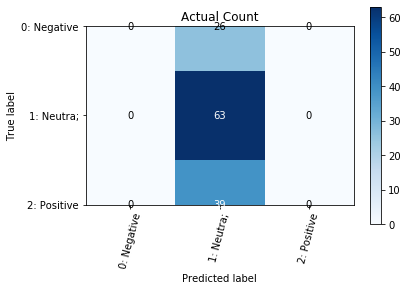

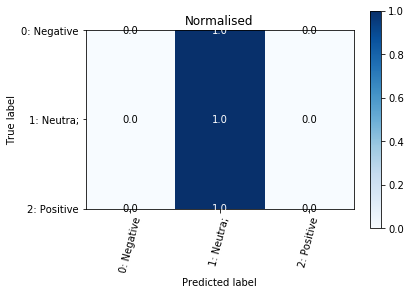

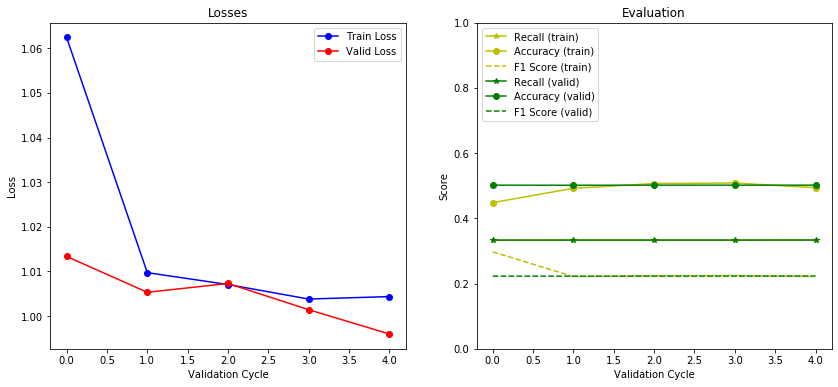

Epoch:   2%|█▌                                                                          | 1/50 [00:23<19:04, 23.36s/it]

================     epoch 2     ===============
Epoch: 2/50, Step: 258, Loss: 63.7004, AvgRec:0.3332, Acc: 0.5015, F1: 0.2227
Epoch: 2/50, Step: 306, Loss: 62.6932, AvgRec:0.3339, Acc: 0.5022, F1: 0.2242
Epoch: 2/50, Step: 357, Loss: 59.6138, AvgRec:0.4010, Acc: 0.5566, F1: 0.3605
Epoch: 2/50, Step: 408, Loss: 57.6837, AvgRec:0.4499, Acc: 0.5920, F1: 0.4179
Epoch: 2/50, Step: 459, Loss: 55.9906, AvgRec:0.4527, Acc: 0.5908, F1: 0.4276
Epoch: 2/50, Step: 510, Loss: 55.2093, AvgRec:0.4507, Acc: 0.5959, F1: 0.4245
Epoch: 2, Loss: 0.8626, AvgRec:0.4507, Acc: 0.5959, F1: 0.4245, LR: 1.20e-04


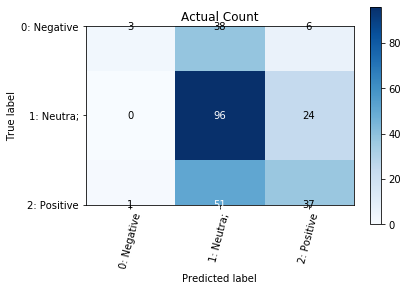

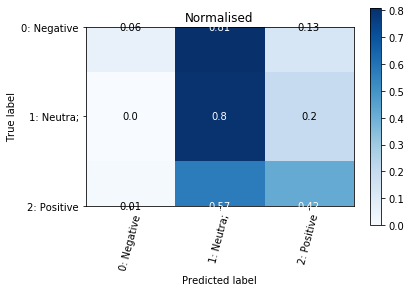

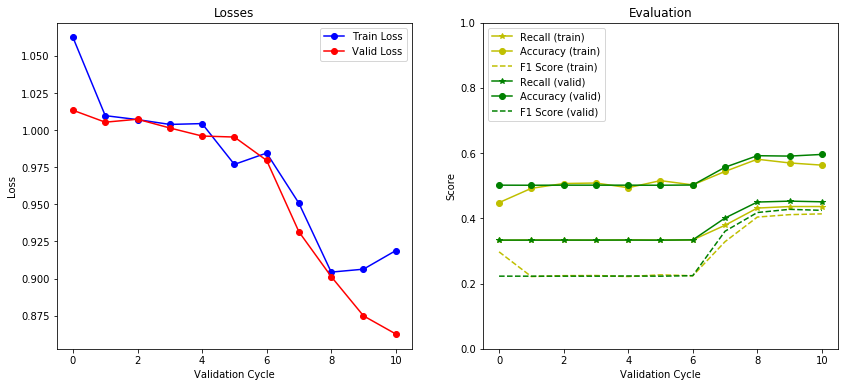

Epoch:   4%|███                                                                         | 2/50 [00:48<19:02, 23.80s/it]

================     epoch 3     ===============
Epoch: 3/50, Step: 561, Loss: 55.0502, AvgRec:0.4826, Acc: 0.5881, F1: 0.4758
Epoch: 3/50, Step: 612, Loss: 55.3172, AvgRec:0.4985, Acc: 0.5933, F1: 0.4935
Epoch: 3/50, Step: 663, Loss: 53.8406, AvgRec:0.4751, Acc: 0.6143, F1: 0.4549
Epoch: 3/50, Step: 714, Loss: 53.5386, AvgRec:0.4949, Acc: 0.6108, F1: 0.4953
Epoch: 3/50, Step: 765, Loss: 53.6823, AvgRec:0.5005, Acc: 0.5994, F1: 0.4973
Epoch: 3, Loss: 0.8388, AvgRec:0.5005, Acc: 0.5994, F1: 0.4973, LR: 1.79e-04


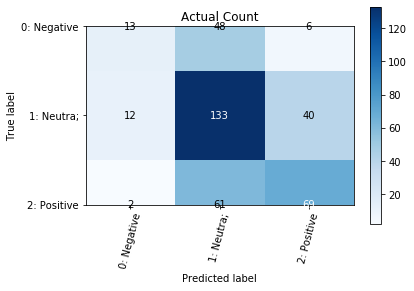

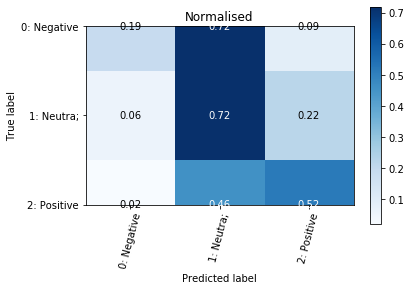

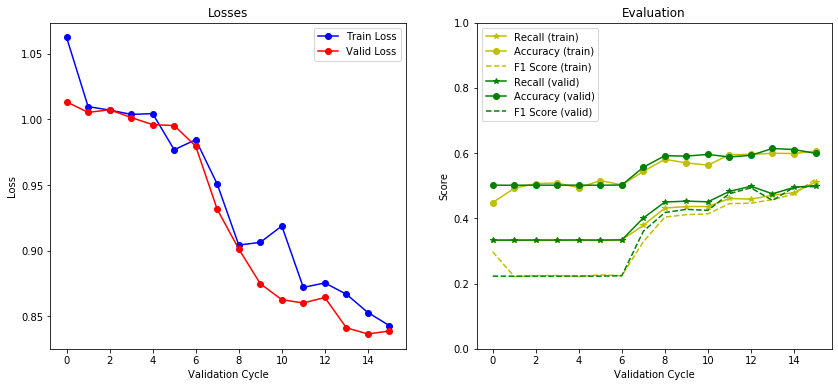

Epoch:   6%|████▌                                                                       | 3/50 [01:10<18:19, 23.40s/it]

================     epoch 4     ===============
Epoch: 4/50, Step: 816, Loss: 52.8909, AvgRec:0.5205, Acc: 0.6062, F1: 0.5294
Epoch: 4/50, Step: 867, Loss: 54.0007, AvgRec:0.5026, Acc: 0.6152, F1: 0.4995
Epoch: 4/50, Step: 918, Loss: 52.1582, AvgRec:0.5409, Acc: 0.6047, F1: 0.5464
Epoch: 4/50, Step: 969, Loss: 52.3089, AvgRec:0.5392, Acc: 0.6140, F1: 0.5470
Epoch: 4/50, Step: 1020, Loss: 51.8634, AvgRec:0.5246, Acc: 0.6160, F1: 0.5304
Epoch: 4, Loss: 0.8104, AvgRec:0.5246, Acc: 0.6160, F1: 0.5304, LR: 2.39e-04


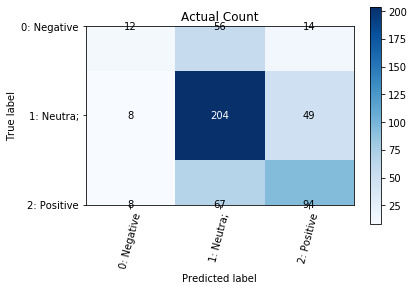

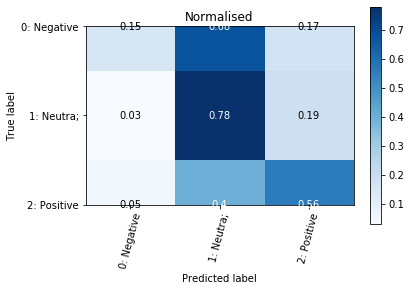

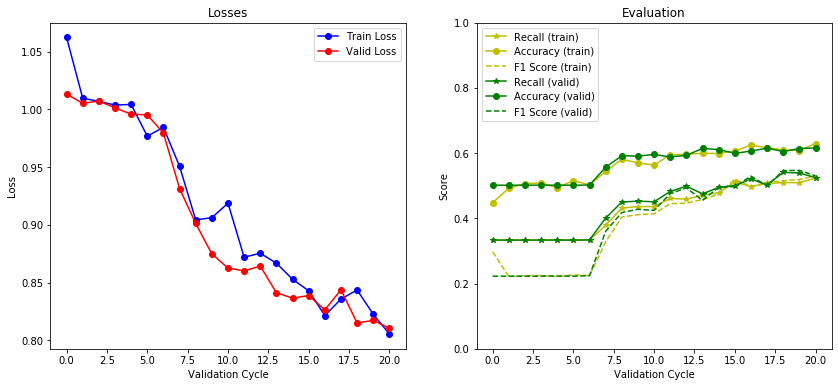

Epoch:   8%|██████                                                                      | 4/50 [01:33<17:44, 23.14s/it]

================     epoch 5     ===============
Epoch: 5/50, Step: 1071, Loss: 52.1218, AvgRec:0.4976, Acc: 0.6194, F1: 0.4844
Epoch: 5/50, Step: 1122, Loss: 52.8758, AvgRec:0.5332, Acc: 0.6277, F1: 0.5432
Epoch: 5/50, Step: 1173, Loss: 51.2941, AvgRec:0.5477, Acc: 0.6287, F1: 0.5608
Epoch: 5/50, Step: 1224, Loss: 51.5893, AvgRec:0.5241, Acc: 0.6260, F1: 0.5280
Epoch: 5/50, Step: 1275, Loss: 50.4776, AvgRec:0.5547, Acc: 0.6304, F1: 0.5595
Epoch: 5, Loss: 0.7887, AvgRec:0.5547, Acc: 0.6304, F1: 0.5595, LR: 2.99e-04


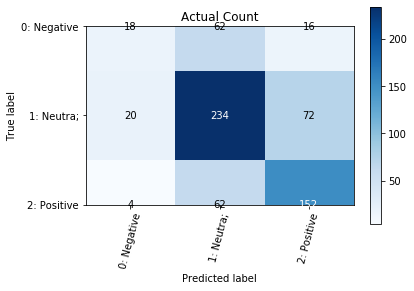

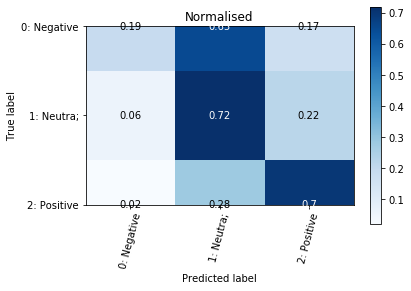

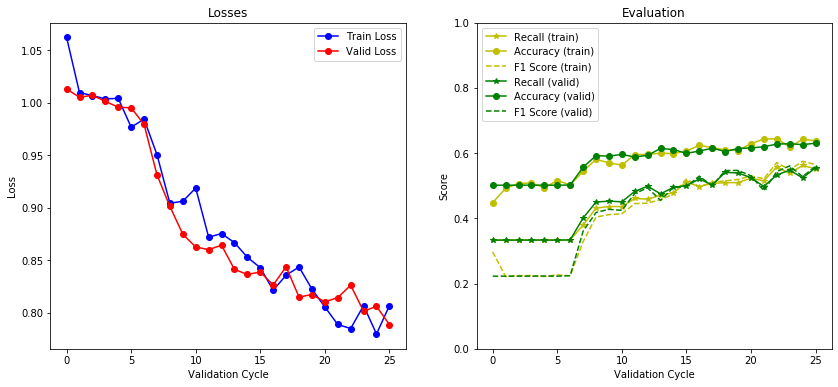

Epoch:  10%|███████▌                                                                    | 5/50 [01:56<17:17, 23.05s/it]

================     epoch 6     ===============
Epoch: 6/50, Step: 1326, Loss: 51.3515, AvgRec:0.5730, Acc: 0.6248, F1: 0.5783
Epoch: 6/50, Step: 1377, Loss: 49.8983, AvgRec:0.5794, Acc: 0.6333, F1: 0.5850
Epoch: 6/50, Step: 1428, Loss: 51.9288, AvgRec:0.5390, Acc: 0.6428, F1: 0.5480
Epoch: 6/50, Step: 1479, Loss: 50.7296, AvgRec:0.5391, Acc: 0.6340, F1: 0.5521
Epoch: 6/50, Step: 1530, Loss: 50.6426, AvgRec:0.5709, Acc: 0.6389, F1: 0.5835
Epoch: 6, Loss: 0.7913, AvgRec:0.5709, Acc: 0.6389, F1: 0.5835, LR: 2.93e-04


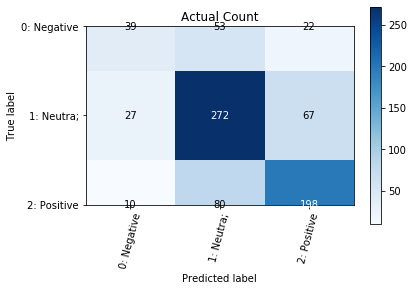

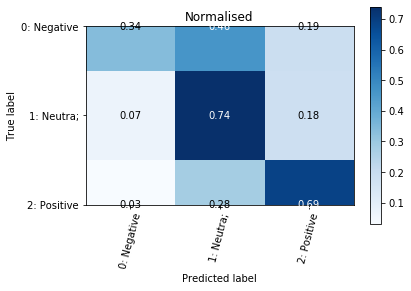

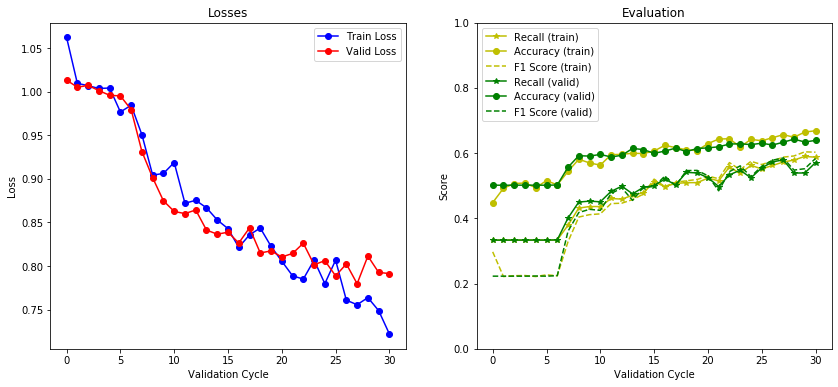

Epoch:  12%|█████████                                                                   | 6/50 [02:18<16:47, 22.90s/it]

================     epoch 7     ===============
Epoch: 7/50, Step: 1581, Loss: 54.5014, AvgRec:0.5463, Acc: 0.6392, F1: 0.5616
Epoch: 7/50, Step: 1632, Loss: 50.8956, AvgRec:0.5897, Acc: 0.6375, F1: 0.5914
Epoch: 7/50, Step: 1683, Loss: 50.0071, AvgRec:0.5728, Acc: 0.6487, F1: 0.5853
Epoch: 7/50, Step: 1734, Loss: 50.0966, AvgRec:0.5954, Acc: 0.6531, F1: 0.6057
Epoch: 7/50, Step: 1785, Loss: 50.5943, AvgRec:0.5497, Acc: 0.6450, F1: 0.5564
Epoch: 7, Loss: 0.7905, AvgRec:0.5497, Acc: 0.6450, F1: 0.5564, LR: 2.87e-04


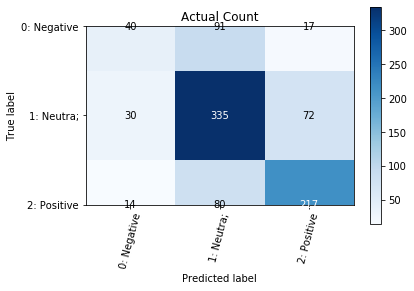

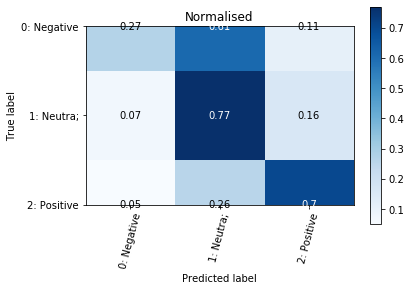

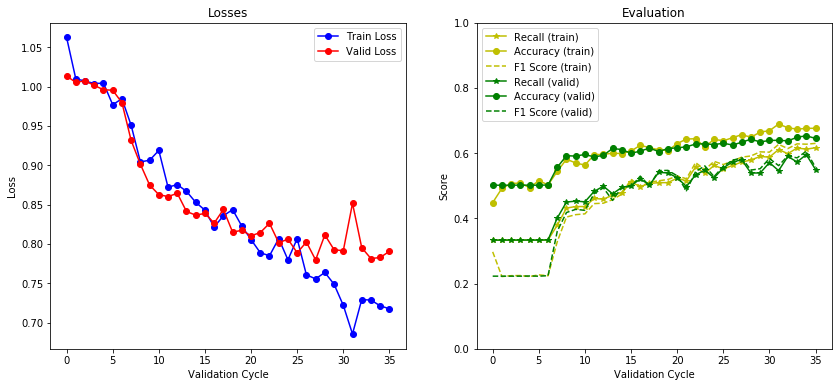

Epoch:  14%|██████████▋                                                                 | 7/50 [02:41<16:20, 22.80s/it]

================     epoch 8     ===============
Epoch: 8/50, Step: 1836, Loss: 51.2314, AvgRec:0.5771, Acc: 0.6504, F1: 0.5911
Epoch: 8/50, Step: 1887, Loss: 50.7418, AvgRec:0.5928, Acc: 0.6440, F1: 0.5988
Epoch: 8/50, Step: 1938, Loss: 50.1473, AvgRec:0.5924, Acc: 0.6504, F1: 0.6027
Epoch: 8/50, Step: 1989, Loss: 50.3927, AvgRec:0.5776, Acc: 0.6528, F1: 0.5895
Epoch: 8/50, Step: 2040, Loss: 50.5239, AvgRec:0.5772, Acc: 0.6567, F1: 0.5872
Epoch: 8, Loss: 0.7894, AvgRec:0.5772, Acc: 0.6567, F1: 0.5872, LR: 2.80e-04


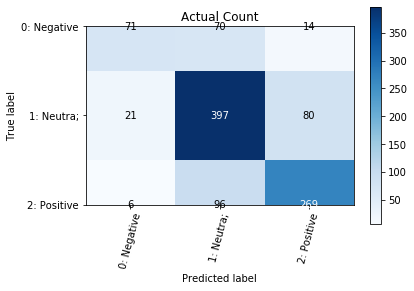

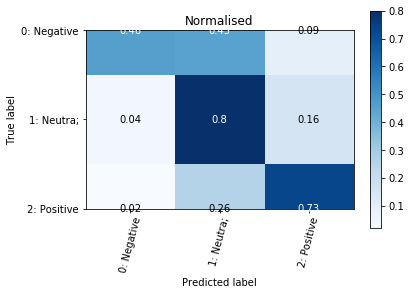

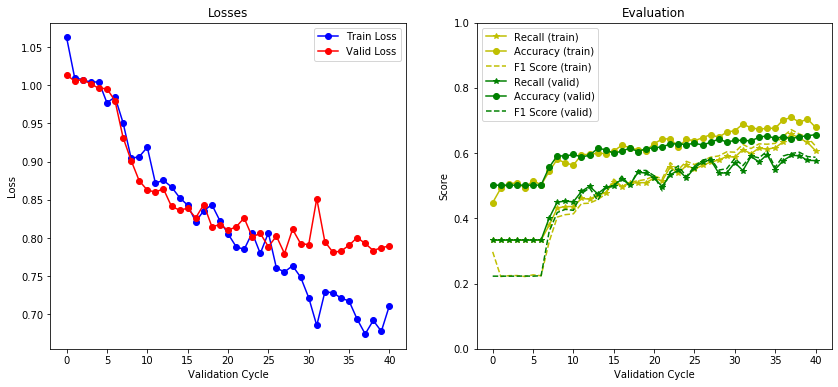

Epoch:  16%|████████████▏                                                               | 8/50 [03:03<15:55, 22.75s/it]

================     epoch 9     ===============
Epoch: 9/50, Step: 2091, Loss: 51.8251, AvgRec:0.5926, Acc: 0.6550, F1: 0.6012
Epoch: 9/50, Step: 2142, Loss: 52.1045, AvgRec:0.5987, Acc: 0.6526, F1: 0.6061
Epoch: 9/50, Step: 2193, Loss: 50.5243, AvgRec:0.6026, Acc: 0.6497, F1: 0.6083
Epoch: 9/50, Step: 2244, Loss: 50.6744, AvgRec:0.6037, Acc: 0.6536, F1: 0.6091
Epoch: 9/50, Step: 2295, Loss: 51.4444, AvgRec:0.5707, Acc: 0.6548, F1: 0.5859
Epoch: 9, Loss: 0.8038, AvgRec:0.5707, Acc: 0.6548, F1: 0.5859, LR: 2.74e-04


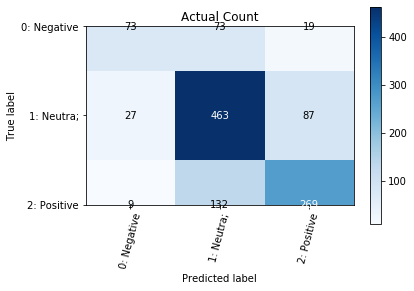

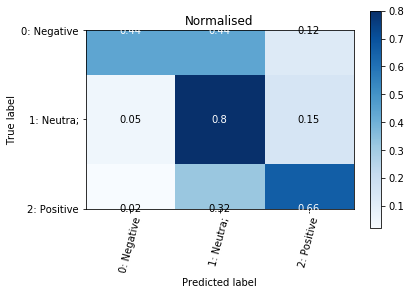

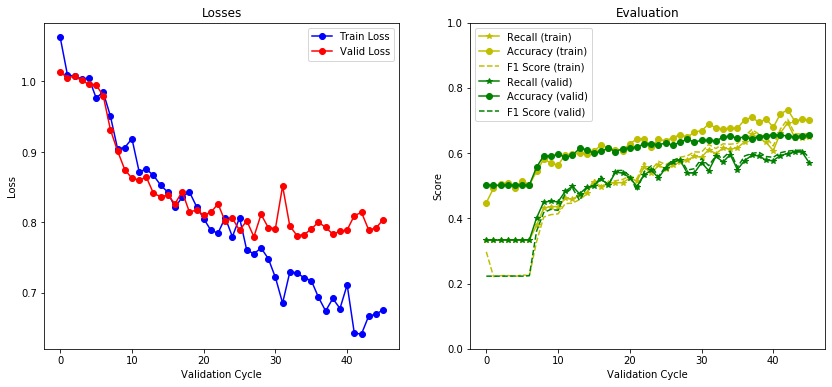

Epoch:  18%|█████████████▋                                                              | 9/50 [03:26<15:33, 22.77s/it]

================     epoch 10     ===============
Epoch: 10/50, Step: 2346, Loss: 53.7685, AvgRec:0.5783, Acc: 0.6558, F1: 0.5928
Epoch: 10/50, Step: 2397, Loss: 52.5578, AvgRec:0.5863, Acc: 0.6553, F1: 0.5979
Epoch: 10/50, Step: 2448, Loss: 53.8680, AvgRec:0.5982, Acc: 0.6514, F1: 0.6043
Epoch: 10/50, Step: 2499, Loss: 50.7443, AvgRec:0.5885, Acc: 0.6604, F1: 0.6035
Epoch: 10/50, Step: 2550, Loss: 52.3338, AvgRec:0.5824, Acc: 0.6560, F1: 0.5966
Epoch: 10, Loss: 0.8177, AvgRec:0.5824, Acc: 0.6560, F1: 0.5966, LR: 2.67e-04


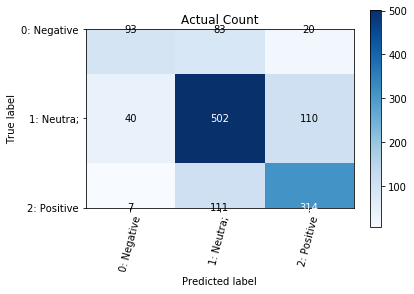

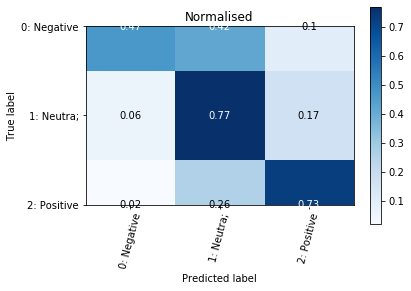

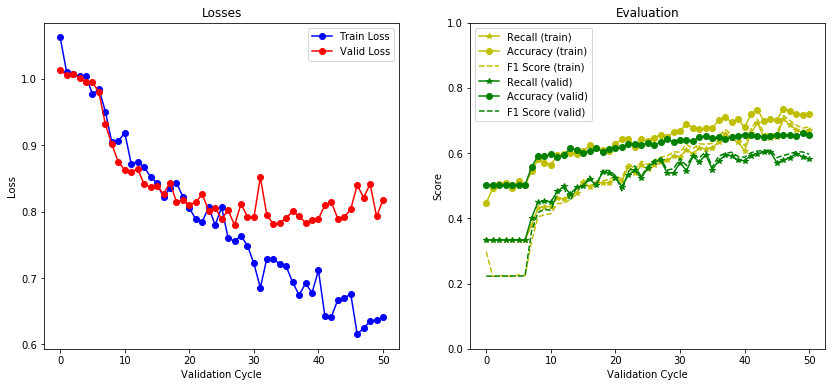

Epoch:  20%|███████████████                                                            | 10/50 [03:49<15:08, 22.71s/it]

================     epoch 11     ===============
Epoch: 11/50, Step: 2601, Loss: 53.4047, AvgRec:0.5790, Acc: 0.6558, F1: 0.5917
Epoch: 11/50, Step: 2652, Loss: 53.0019, AvgRec:0.5706, Acc: 0.6553, F1: 0.5844
Epoch: 11/50, Step: 2703, Loss: 51.3112, AvgRec:0.6052, Acc: 0.6584, F1: 0.6129
Epoch: 11/50, Step: 2754, Loss: 52.3126, AvgRec:0.6185, Acc: 0.6533, F1: 0.6177
Epoch: 11/50, Step: 2805, Loss: 50.7761, AvgRec:0.5976, Acc: 0.6570, F1: 0.6087
Epoch: 11, Loss: 0.7934, AvgRec:0.5976, Acc: 0.6570, F1: 0.6087, LR: 2.60e-04


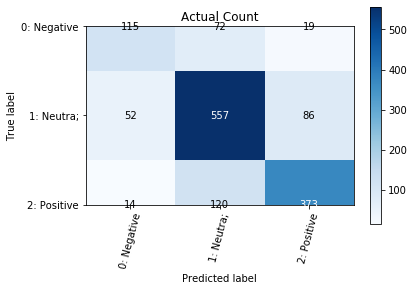

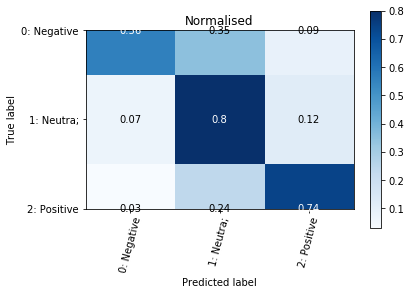

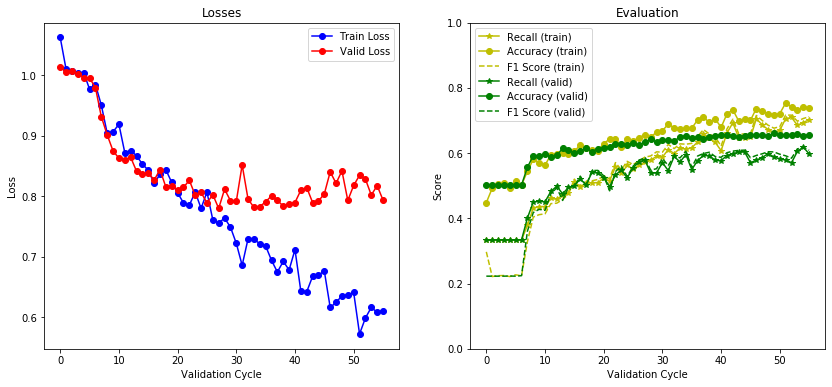

Epoch:  22%|████████████████▌                                                          | 11/50 [04:11<14:44, 22.68s/it]

================     epoch 12     ===============
Epoch: 12/50, Step: 2856, Loss: 56.0713, AvgRec:0.6092, Acc: 0.6499, F1: 0.6129
Epoch: 12/50, Step: 2907, Loss: 52.8056, AvgRec:0.6146, Acc: 0.6567, F1: 0.6166
Epoch: 12/50, Step: 2958, Loss: 53.3566, AvgRec:0.5884, Acc: 0.6531, F1: 0.5976
Epoch: 12/50, Step: 3009, Loss: 53.1342, AvgRec:0.6052, Acc: 0.6550, F1: 0.6097
Epoch: 12/50, Step: 3060, Loss: 53.6384, AvgRec:0.5987, Acc: 0.6599, F1: 0.6099
Epoch: 12, Loss: 0.8381, AvgRec:0.5987, Acc: 0.6599, F1: 0.6099, LR: 2.54e-04


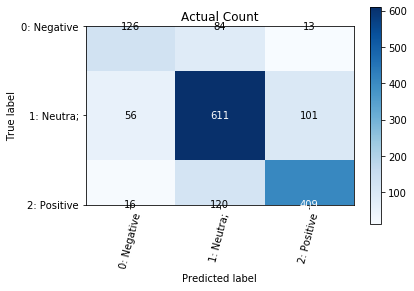

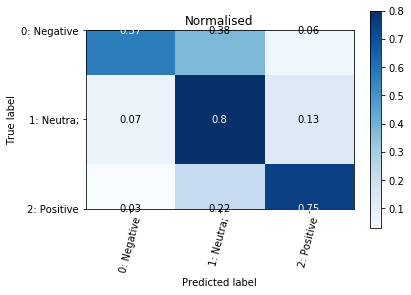

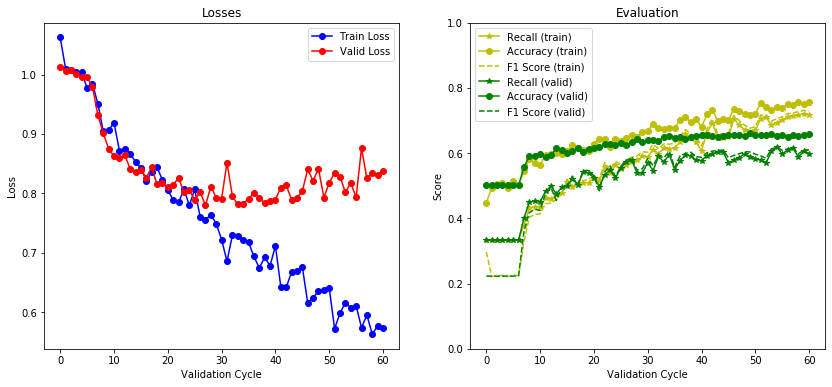

Epoch:  24%|██████████████████                                                         | 12/50 [04:34<14:21, 22.66s/it]

================     epoch 13     ===============
Epoch: 13/50, Step: 3111, Loss: 55.2578, AvgRec:0.6151, Acc: 0.6519, F1: 0.6135
Epoch: 13/50, Step: 3162, Loss: 53.9703, AvgRec:0.6071, Acc: 0.6514, F1: 0.6090
Epoch: 13/50, Step: 3213, Loss: 54.4462, AvgRec:0.6010, Acc: 0.6597, F1: 0.6119
Epoch: 13/50, Step: 3264, Loss: 56.1089, AvgRec:0.6200, Acc: 0.6553, F1: 0.6195
Epoch: 13/50, Step: 3315, Loss: 56.3081, AvgRec:0.6036, Acc: 0.6543, F1: 0.6097
Epoch: 13, Loss: 0.8798, AvgRec:0.6036, Acc: 0.6543, F1: 0.6097, LR: 2.47e-04


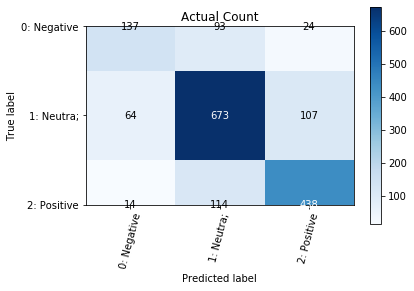

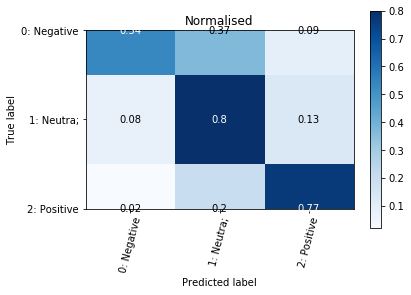

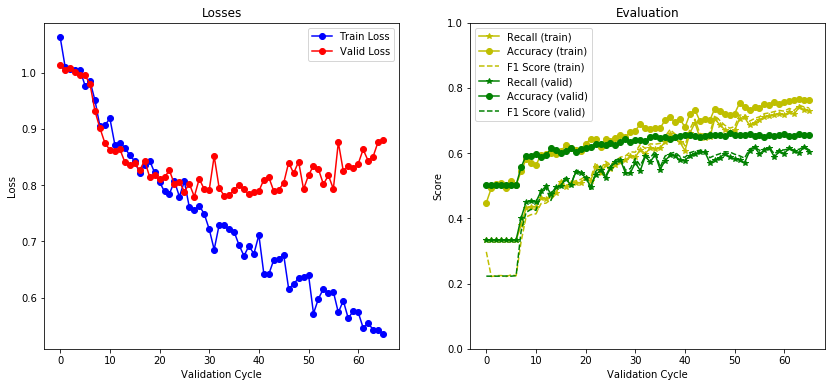

Epoch:  26%|███████████████████▌                                                       | 13/50 [04:57<13:59, 22.68s/it]

================     epoch 14     ===============
Epoch: 14/50, Step: 3366, Loss: 57.8058, AvgRec:0.6167, Acc: 0.6516, F1: 0.6162
Epoch: 14/50, Step: 3417, Loss: 54.2495, AvgRec:0.6160, Acc: 0.6602, F1: 0.6223
Epoch: 14/50, Step: 3468, Loss: 57.8161, AvgRec:0.5979, Acc: 0.6575, F1: 0.6101
Epoch: 14/50, Step: 3519, Loss: 56.4509, AvgRec:0.5933, Acc: 0.6616, F1: 0.6083
Epoch: 14/50, Step: 3570, Loss: 58.1187, AvgRec:0.6098, Acc: 0.6604, F1: 0.6188
Epoch: 14, Loss: 0.9081, AvgRec:0.6098, Acc: 0.6604, F1: 0.6188, LR: 2.40e-04


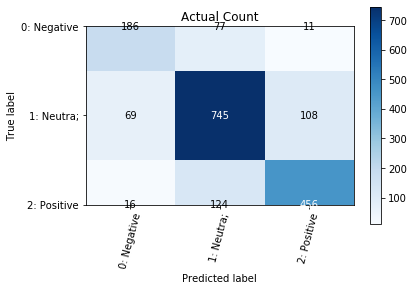

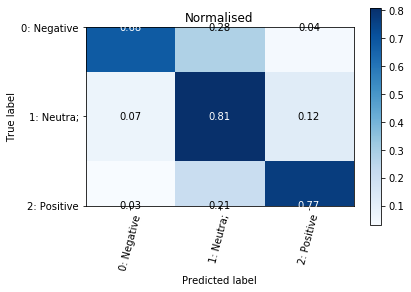

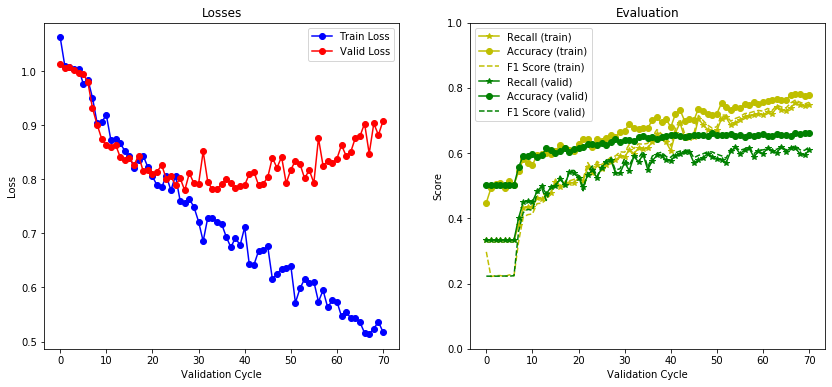

Epoch:  28%|█████████████████████                                                      | 14/50 [05:20<13:43, 22.87s/it]

================     epoch 15     ===============
Epoch: 15/50, Step: 3621, Loss: 57.3427, AvgRec:0.6061, Acc: 0.6567, F1: 0.6107
Epoch: 15/50, Step: 3672, Loss: 58.3528, AvgRec:0.6084, Acc: 0.6565, F1: 0.6148
Epoch: 15/50, Step: 3723, Loss: 59.4799, AvgRec:0.6217, Acc: 0.6377, F1: 0.6114
Epoch: 15/50, Step: 3774, Loss: 57.9901, AvgRec:0.6184, Acc: 0.6545, F1: 0.6187
Epoch: 15/50, Step: 3825, Loss: 57.0756, AvgRec:0.6015, Acc: 0.6597, F1: 0.6133
Epoch: 15, Loss: 0.8918, AvgRec:0.6015, Acc: 0.6597, F1: 0.6133, LR: 2.34e-04


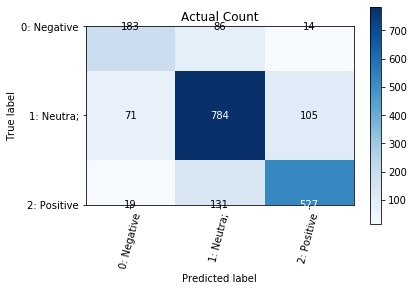

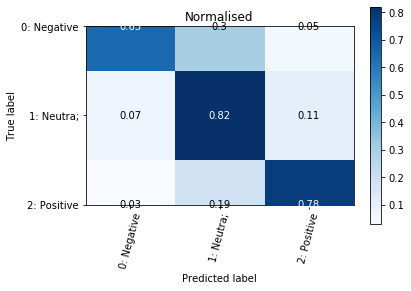

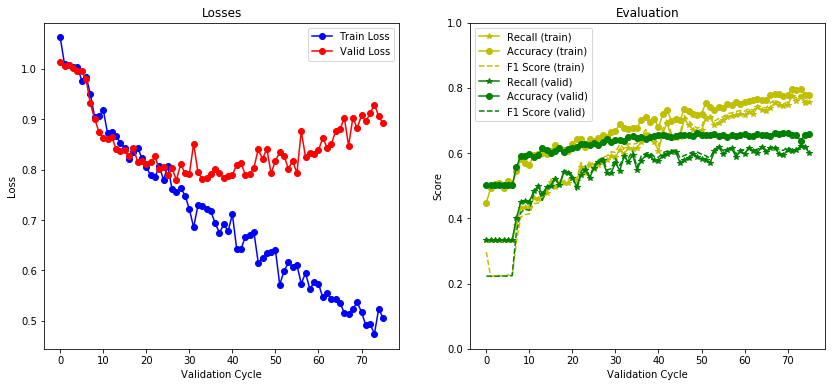

Epoch:  30%|██████████████████████▌                                                    | 15/50 [05:43<13:17, 22.80s/it]

================     epoch 16     ===============
Epoch: 16/50, Step: 3876, Loss: 59.4793, AvgRec:0.5992, Acc: 0.6562, F1: 0.6086
Epoch: 16/50, Step: 3927, Loss: 61.0399, AvgRec:0.5946, Acc: 0.6558, F1: 0.6058
Epoch: 16/50, Step: 3978, Loss: 56.1230, AvgRec:0.6151, Acc: 0.6592, F1: 0.6209
Epoch: 16/50, Step: 4029, Loss: 59.3607, AvgRec:0.5992, Acc: 0.6616, F1: 0.6101
Epoch: 16/50, Step: 4080, Loss: 62.0399, AvgRec:0.5984, Acc: 0.6653, F1: 0.6122
Epoch: 16, Loss: 0.9694, AvgRec:0.5984, Acc: 0.6653, F1: 0.6122, LR: 2.27e-04


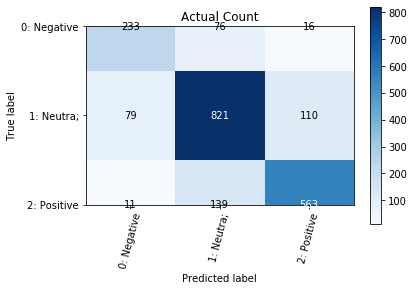

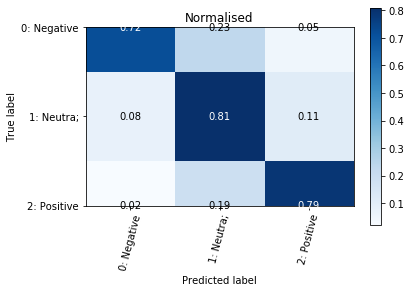

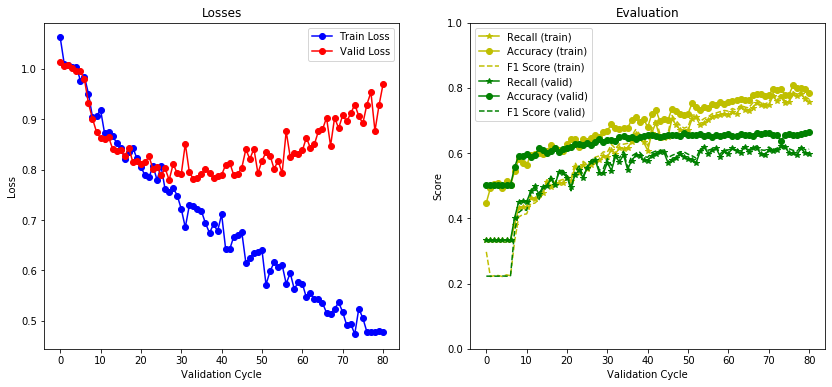

Epoch:  32%|████████████████████████                                                   | 16/50 [06:05<12:53, 22.74s/it]

================     epoch 17     ===============
Epoch: 17/50, Step: 4131, Loss: 63.7936, AvgRec:0.5936, Acc: 0.6550, F1: 0.6053
Epoch: 17/50, Step: 4182, Loss: 62.4858, AvgRec:0.5842, Acc: 0.6511, F1: 0.5986
Epoch: 17/50, Step: 4233, Loss: 60.4617, AvgRec:0.5992, Acc: 0.6677, F1: 0.6151
Epoch: 17/50, Step: 4284, Loss: 61.8257, AvgRec:0.6148, Acc: 0.6550, F1: 0.6178
Epoch: 17/50, Step: 4335, Loss: 62.3828, AvgRec:0.5969, Acc: 0.6599, F1: 0.6078
Epoch: 17, Loss: 0.9747, AvgRec:0.5969, Acc: 0.6599, F1: 0.6078, LR: 2.20e-04


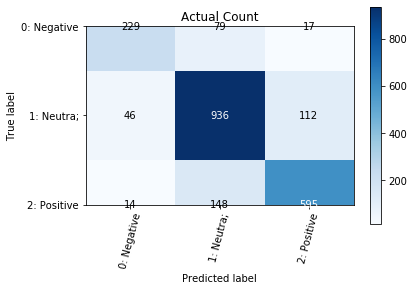

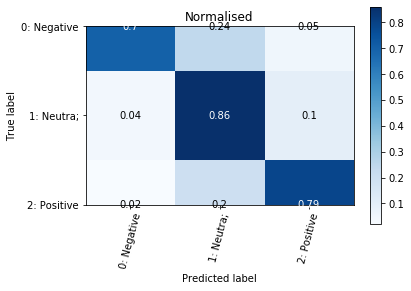

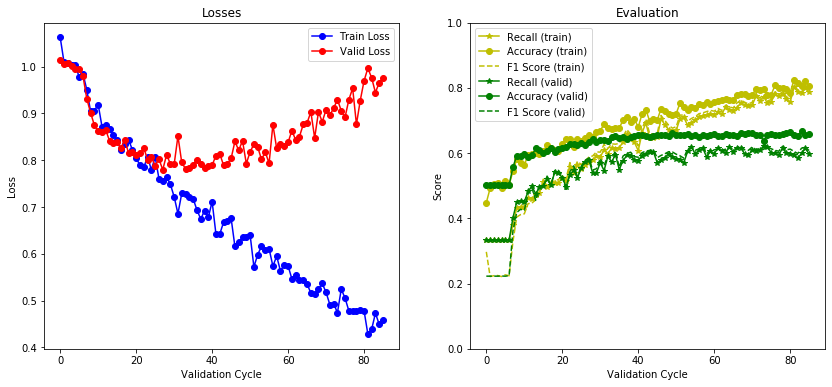

Process Time (sec): 389.76352669999994


,Recall,Accuracy,F1(macro),Total_Time,ms/text
20632,0.6098,0.6599,0.6078,389.763527,18.891214


In [19]:
# Define the training parameters
num_samples = [20632]
epochs=50
patience=3
batch_size=64
seq_len = 40
lr=3e-4
clip=5

# Run!
result_lstm, model_trained_lstm = train_cycles(data_df['Text'], data_df['label'], word2idx, num_samples, 'LSTM', epochs, patience, batch_size, seq_len, lr, clip)

# Save the model and show the result
result_lstm